<a href="https://colab.research.google.com/github/FikretOguzhan/Dog-Breeds-Classifier/blob/main/Dog_Breed_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Uploading Data from Kaggle

In [ ]:
! pip install kaggle

from google.colab import drive
drive.mount("/content/drive")

! mkdir ~/.kaggle
!cp /content/drive/MyDrive/Classifier/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download jessicali9530/Stanford-Dogs-Dataset
! unzip Stanford-Dogs-Dataset.zip #Extracting the files

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: images/Images/n02108089-boxer/n02108089_11687.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_117.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_11807.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_11875.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_122.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12232.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_125.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12738.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12739.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12827.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_13340.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_13526.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_1353.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_1355.jpg  
  inflating: images/Images/n02108089-boxer/n0210808

#### Import Libraries

In [ ]:
from torchvision import transforms, datasets, models
import torch 
from torch import optim, cuda 
from torch.utils.data import DataLoader, sampler, random_split
import torch.nn as nn

from PIL import Image 
import numpy as np
import pandas as pd
import os 
import seaborn as sns
import matplotlib.pyplot as plt

import xml.etree.ElementTree as ET
import pathlib

In [ ]:
annotation_dir = "/content/annotations/Annotation/"
images_dir = "/content/images/Images/"
data_dir = "/content/"

In [ ]:
print(os.listdir(images_dir))

['n02100735-English_setter', 'n02105162-malinois', 'n02110806-basenji', 'n02101388-Brittany_spaniel', 'n02099601-golden_retriever', 'n02093754-Border_terrier', 'n02112018-Pomeranian', 'n02108000-EntleBucher', 'n02085620-Chihuahua', 'n02109525-Saint_Bernard', 'n02102973-Irish_water_spaniel', 'n02104365-schipperke', 'n02097130-giant_schnauzer', 'n02096437-Dandie_Dinmont', 'n02089867-Walker_hound', 'n02093256-Staffordshire_bullterrier', 'n02107683-Bernese_mountain_dog', 'n02095889-Sealyham_terrier', 'n02112706-Brabancon_griffon', 'n02091134-whippet', 'n02096585-Boston_bull', 'n02109961-Eskimo_dog', 'n02111129-Leonberg', 'n02101006-Gordon_setter', 'n02089973-English_foxhound', 'n02110627-affenpinscher', 'n02087046-toy_terrier', 'n02098286-West_Highland_white_terrier', 'n02096294-Australian_terrier', 'n02097209-standard_schnauzer', 'n02085936-Maltese_dog', 'n02105855-Shetland_sheepdog', 'n02098413-Lhasa', 'n02107574-Greater_Swiss_Mountain_dog', 'n02091244-Ibizan_hound', 'n02094433-Yorkshire

In [ ]:
categories = os.listdir(images_dir)
num_of_categories = len(categories)
breed_list = sorted(os.listdir(images_dir))
breed_list[:3]

['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog']

In [ ]:
categories[:3]

['n02100735-English_setter', 'n02105162-malinois', 'n02110806-basenji']

In [ ]:
print("Counts of Breeds = {}".format(num_of_categories))

Counts of Breeds = 120


##### Let's check the number of images by breeds.

In [ ]:
breed_count_graph = pd.DataFrame(
    index = [i.split("-", 1)[1]
             for i in categories],
    data = [len(os.listdir(images_dir + "/" + name))
              for name in categories],
    columns = ["number_of_images"]
)

breed_count_graph.head()

,number_of_images
English_setter,161
malinois,150
basenji,209
Brittany_spaniel,152
golden_retriever,150


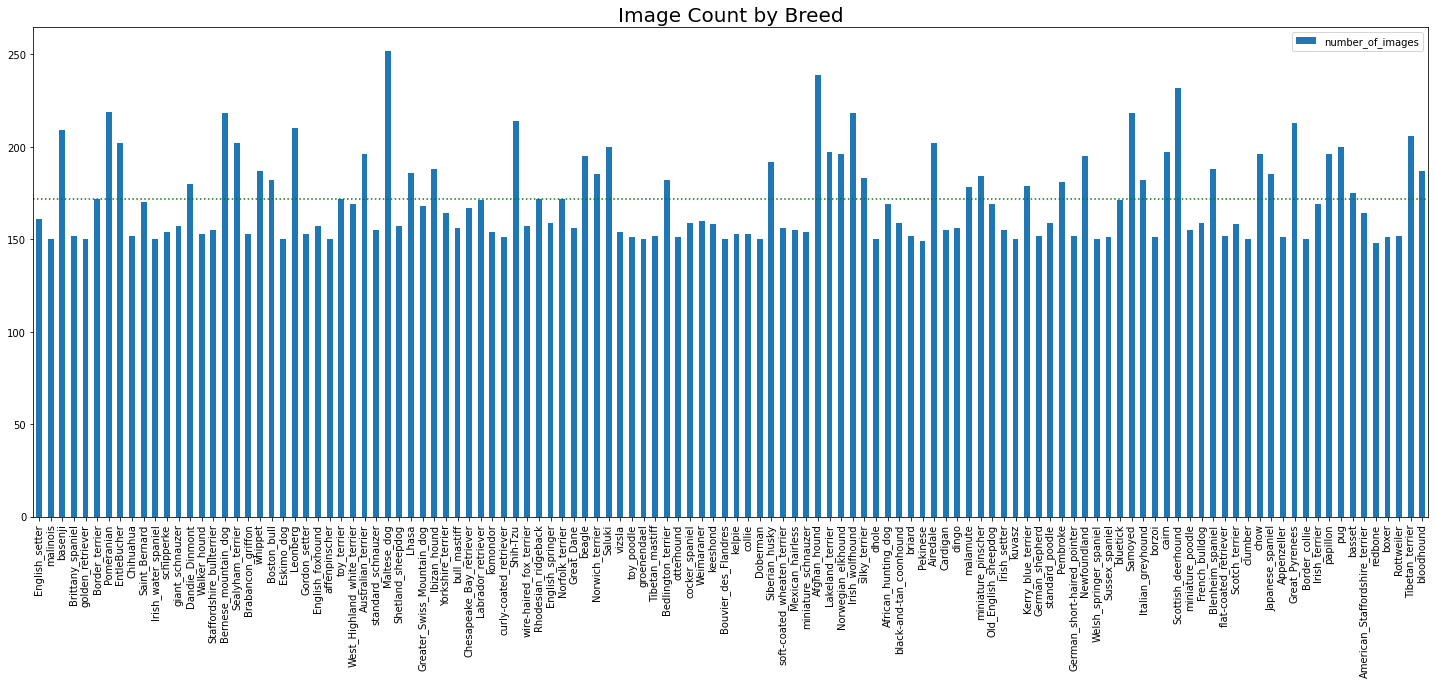

Mean Value of All Dog Breed Numbers : 171.5


In [ ]:
fig = breed_count_graph.plot(kind = "bar", figsize = (25,9))
mean_of_pictures = breed_count_graph["number_of_images"].mean()
fig.axhline(mean_of_pictures, color = "g", linestyle = ":", label = "Mean of Pictures")
plt.title("Image Count by Breed", fontsize = 20)
plt.show()
print("Mean Value of All Dog Breed Numbers :", mean_of_pictures)

##### Let's see some images

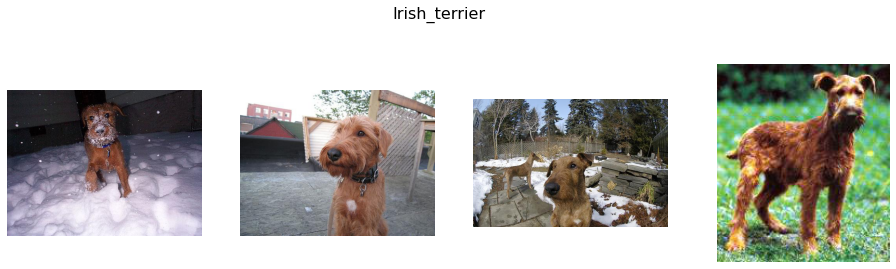

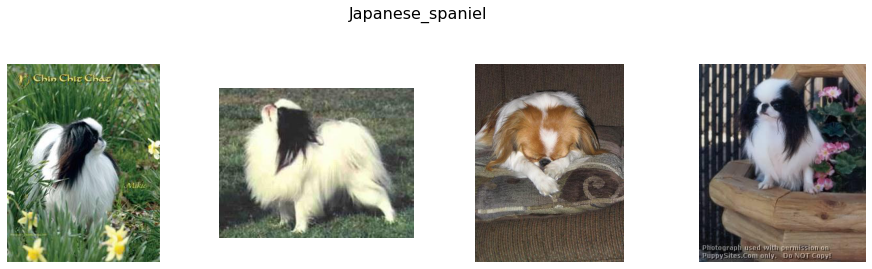

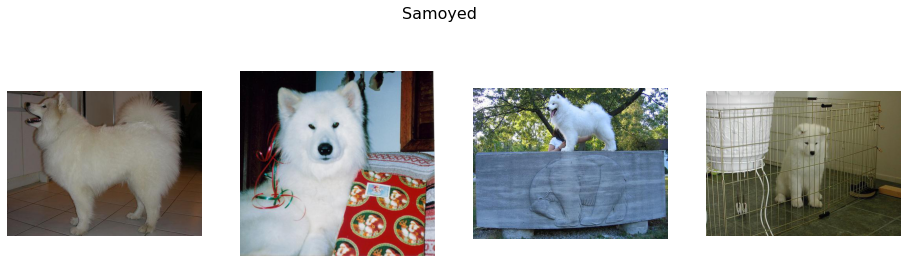

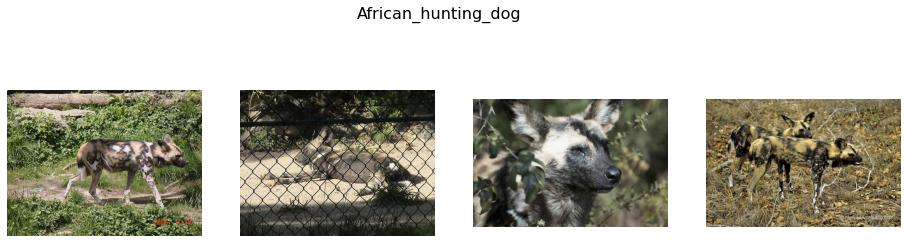

In [ ]:
def image_show(path, classes):
  fig = plt.figure(figsize=(16, 8))
  fig.patch.set_facecolor('white')
  plt.suptitle("{}".format(classes.split("-")[1]),
                 color="black", fontsize=16)
  image = os.listdir(path + "/" + classes)[:4]

  for i in range(4):
    img = plt.imread(path + "/" + classes + "/" + image[i])
    plt.subplot(4/4+1, 4 , i+1)
    plt.imshow(img)
    plt.axis('off')
  plt.show()


for i in np.random.randint(0, len(categories), size=4):
    image_show(images_dir, categories[i])

##### After cropping the images we create a new file to save them.

In [ ]:
os.mkdir("data_cropped")
for i in categories:
  os.mkdir("data_cropped/" + i)
print(len(os.listdir("data_cropped")))

120


##### Cropping images

In [ ]:
for i in os.listdir("data_cropped"):
  for file in os.listdir(annotation_dir + i):
    img = Image.open(images_dir + i + "/" + file + ".jpg")
    tree = ET.parse(annotation_dir + i + "/" + file)
    xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
    xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
    ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
    ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
    
    img_cropped = img.crop((xmin,ymin,xmax,ymax))
    img_cropped = img.convert("RGB")
    img_cropped.save("data_cropped/" + i + "/" + file + ".jpg")

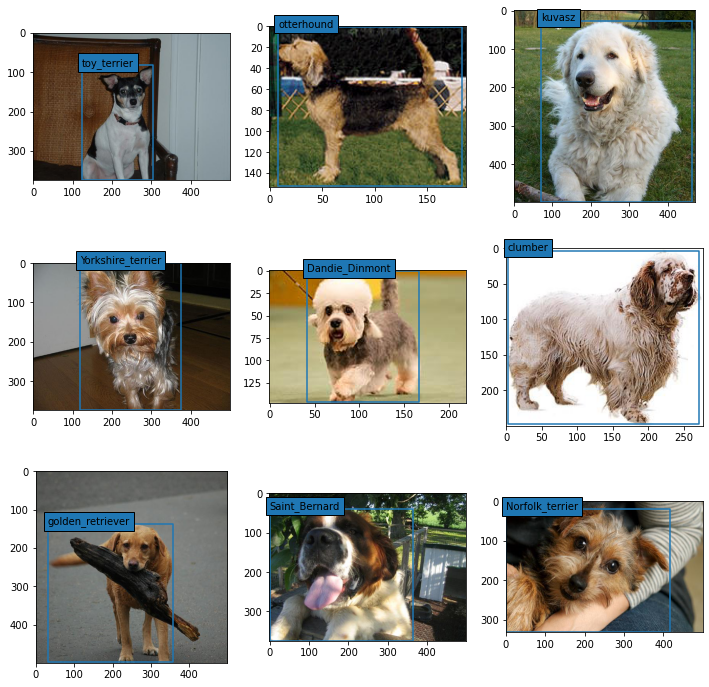

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(331 + i) 
    breed = np.random.choice(breed_list)
    dog = np.random.choice(os.listdir('/content/annotations/Annotation/' + breed))
    img = Image.open('/content/images/Images/' + breed + '/' + dog + '.jpg') 
    tree = ET.parse('/content/annotations/Annotation/' + breed + '/' + dog)
    root = tree.getroot()
    objects = root.findall('object')
    plt.imshow(img)
    for o in objects:
        bndbox = o.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin])
        plt.text(xmin, ymin, o.find('name').text, bbox={'ec': None})

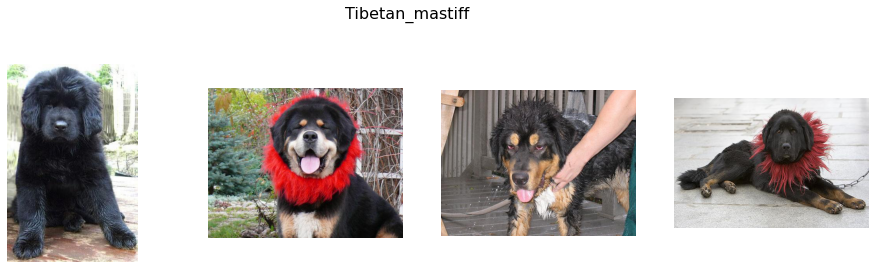

In [ ]:
data_cropped_dir = "/content/data_cropped"
cropped_categories = os.listdir(data_cropped_dir)
for i in np.random.randint(0, len(cropped_categories), size=1):
    image_show(data_cropped_dir, cropped_categories[i])

In [ ]:
img_transforms = {
    "train" :
    transforms.Compose([
        transforms.RandomResizedCrop(size = (300, 600), scale = (0.2, 0.8)),
        transforms.RandomRotation(degrees = (-15, 15)),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size = 299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "test" : 
     transforms.Compose([
        transforms.Resize(size=299),
        transforms.CenterCrop(size=299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [ ]:
batch = 128
data = datasets.ImageFolder(root = "data_cropped")

train_data_len = int(len(data)*0.8)
valid_data_len = int((len(data) - train_data_len)/2)
test_data_len = int(len(data) - train_data_len - valid_data_len)

train_data, val_data, test_data = random_split(data, [train_data_len, valid_data_len, test_data_len])

train_data.dataset.transform = img_transforms['train']
val_data.dataset.transform = img_transforms['test']
test_data.dataset.transform = img_transforms['test']


print("Length of train data: ", len(train_data), "\n",
      "Length of val data:",  len(val_data), "\n", 
      "Length of test data:", len(test_data))

Length of train data:  16464 
 Length of val data: 2058 
 Length of test data: 2058


In [ ]:
train_loader = DataLoader(dataset = train_data, batch_size=batch, shuffle=True)
val_loader = DataLoader(dataset = val_data, batch_size=batch, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch, shuffle=True)

In [ ]:
trainiter = iter(train_loader) # tüm batch i alalım
features, labels = next(trainiter)  #Görüntüleri ve onların etiketlerini elde edelim 
print(features.shape, labels.shape)

torch.Size([128, 3, 299, 299]) torch.Size([128])


### Model 1: Xception

In [ ]:
#!pip install timm
import timm
model_xception = timm.create_model('xception', pretrained=True)

In [ ]:
model_xception

Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU(inplace=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Conv

In [ ]:
# Freeze early layers
for param in model_xception.parameters():
    param.requires_grad = False

n_classes = 120
n_inputs = model_xception.fc.in_features

model_xception.fc = nn.Sequential(
    nn.Linear(n_inputs, 1024),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024, n_classes),
    nn.LogSoftmax(dim=1))

model_xception.fc

Sequential(
  (0): Linear(in_features=2048, out_features=1024, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=1024, out_features=120, bias=True)
  (4): LogSoftmax(dim=1)
)

In [ ]:
model_xception.class_to_idx = data.class_to_idx
model_xception.idx_to_class = {
    idx: class_
    for class_, idx in model_xception.class_to_idx.items()
}

list(model_xception.idx_to_class.items())

[(0, 'n02085620-Chihuahua'),
 (1, 'n02085782-Japanese_spaniel'),
 (2, 'n02085936-Maltese_dog'),
 (3, 'n02086079-Pekinese'),
 (4, 'n02086240-Shih-Tzu'),
 (5, 'n02086646-Blenheim_spaniel'),
 (6, 'n02086910-papillon'),
 (7, 'n02087046-toy_terrier'),
 (8, 'n02087394-Rhodesian_ridgeback'),
 (9, 'n02088094-Afghan_hound'),
 (10, 'n02088238-basset'),
 (11, 'n02088364-beagle'),
 (12, 'n02088466-bloodhound'),
 (13, 'n02088632-bluetick'),
 (14, 'n02089078-black-and-tan_coonhound'),
 (15, 'n02089867-Walker_hound'),
 (16, 'n02089973-English_foxhound'),
 (17, 'n02090379-redbone'),
 (18, 'n02090622-borzoi'),
 (19, 'n02090721-Irish_wolfhound'),
 (20, 'n02091032-Italian_greyhound'),
 (21, 'n02091134-whippet'),
 (22, 'n02091244-Ibizan_hound'),
 (23, 'n02091467-Norwegian_elkhound'),
 (24, 'n02091635-otterhound'),
 (25, 'n02091831-Saluki'),
 (26, 'n02092002-Scottish_deerhound'),
 (27, 'n02092339-Weimaraner'),
 (28, 'n02093256-Staffordshire_bullterrier'),
 (29, 'n02093428-American_Staffordshire_terrier'),


In [ ]:
#!pip install torchsummary

from torchsummary import summary 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print('The model will run on', device)

The model will run on cuda


In [ ]:
#!pip install poutyne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 210 kB 4.8 MB/s 
     |████████████████████████████████| 512 kB 52.5 MB/s 


In [ ]:
from poutyne.framework import ModelCheckpoint 
from poutyne.framework import EarlyStopping 
from poutyne.framework import Model
#!pip install livelossplot
from livelossplot import PlotLossesPoutyne

In [ ]:
learning_rate = 0.1
epochs = 10

def train_model(model_name, pytorch_model):
    plotlosses = PlotLossesPoutyne()

    callbacks = [
        # Saving the final weights
        ModelCheckpoint(model_name + '_last_epoch.ckpt', \
                        temporary_filename='last_epoch.ckpt.tmp'),
        # EarlyStopping
        EarlyStopping(monitor='val_acc', patience=1, verbose=True, mode='max'),
        # Adding callbacks to LiveLossPlot
        plotlosses
    ]
    optimizer = optim.SGD(pytorch_model.parameters(), lr=learning_rate)
    loss_function = nn.CrossEntropyLoss()
    model = Model(pytorch_model, optimizer, loss_function, batch_metrics=['accuracy'])
    model.to(device)
    model.fit_generator(train_loader, val_loader, epochs=epochs, callbacks=callbacks)
    test_loss, test_acc = model.evaluate_generator(test_loader)
    print(f'Test:\n\tLoss: {test_loss: .3f}\n\tAccuracy: {test_acc: .3f}')

    return None 

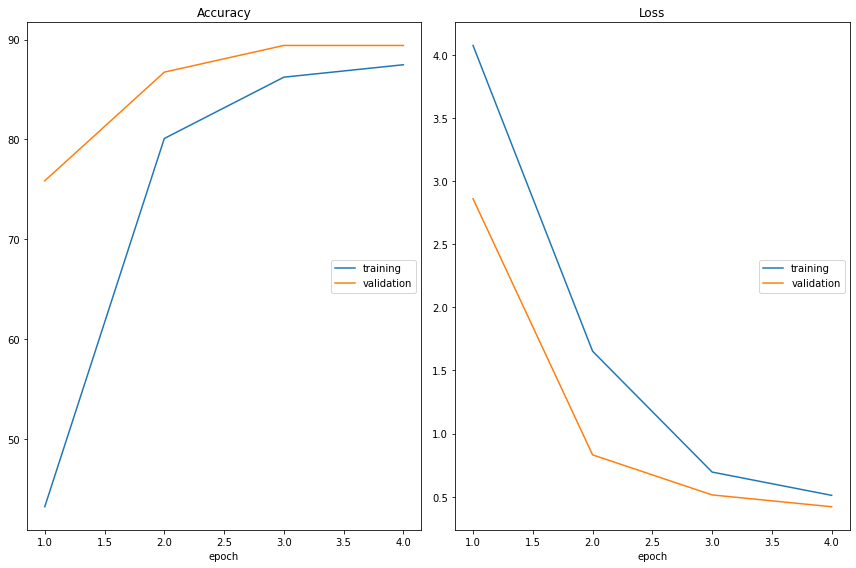

Accuracy
	training         	 (min:   43.209, max:   87.476, cur:   87.476)
	validation       	 (min:   75.850, max:   89.407, cur:   89.407)
Loss
	training         	 (min:    0.511, max:    4.074, cur:    0.511)
	validation       	 (min:    0.421, max:    2.860, cur:    0.421)
Test steps: 17 30.49s test_loss: 0.435908 test_acc: 88.241011                               
Test:
	Loss:  0.436
	Accuracy:  88.241


In [ ]:
train_model(model_name='model_xception', pytorch_model=model_xception)

### Model 2: ResNet18

In [ ]:
model_resnet18 = models.resnet18(pretrained=True)

In [ ]:
model_resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Freeze early layers
for param in model_resnet18.parameters():
    param.requires_grad = False

n_classes = 120
n_inputs = model_resnet18.fc.in_features

model_resnet18.fc = nn.Sequential(
    nn.Linear(n_inputs, 1024),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024, n_classes),
    nn.LogSoftmax(dim=1))

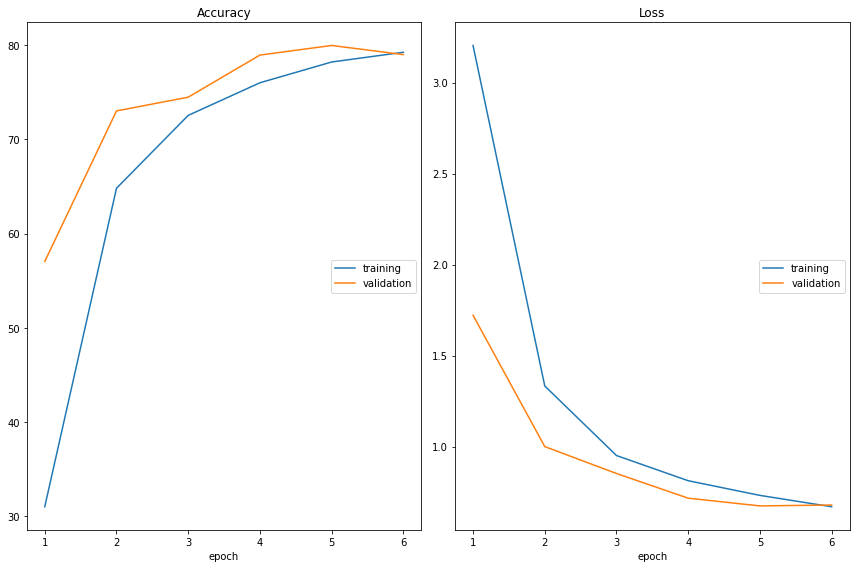

Accuracy
	training         	 (min:   31.013, max:   79.258, cur:   79.258)
	validation       	 (min:   57.046, max:   79.981, cur:   79.009)
Loss
	training         	 (min:    0.670, max:    3.204, cur:    0.670)
	validation       	 (min:    0.674, max:    1.722, cur:    0.679)
Test steps: 17 16.99s test_loss: 0.699279 test_acc: 78.134111                               
Test:
	Loss:  0.699
	Accuracy:  78.134


In [ ]:
train_model(model_name='model_resnet18', pytorch_model=model_resnet18)

### Model 3: ResNet50

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights
model_resnet_50 = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
model_resnet_50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Freeze early layers
for param in model_resnet_50.parameters():
    param.requires_grad = False

n_classes = 120
n_inputs = model_resnet_50.fc.in_features

model_resnet_50.fc = nn.Sequential(
    nn.Linear(n_inputs, 1024),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024, n_classes),
    nn.LogSoftmax(dim=1))

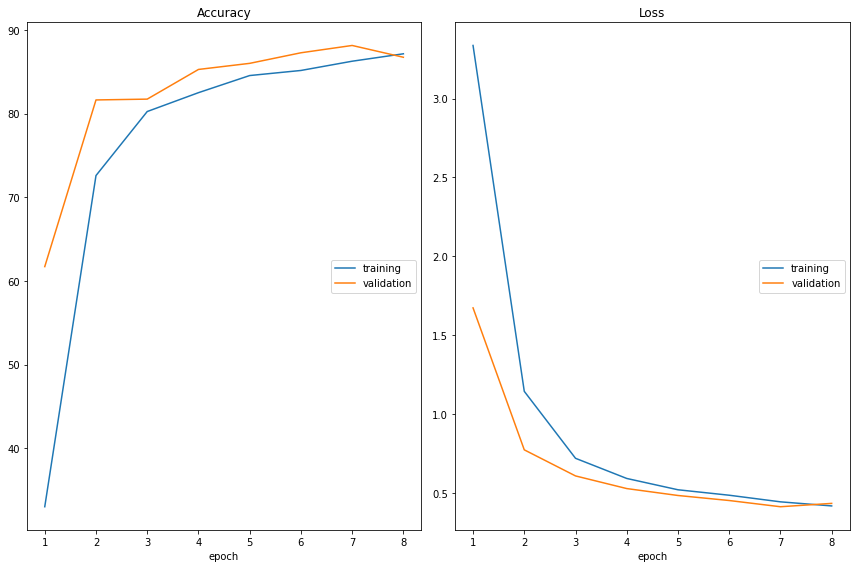

Accuracy
	training         	 (min:   33.011, max:   87.148, cur:   87.148)
	validation       	 (min:   61.710, max:   88.144, cur:   86.735)
Loss
	training         	 (min:    0.419, max:    3.337, cur:    0.419)
	validation       	 (min:    0.414, max:    1.674, cur:    0.435)
Test steps: 17 24.46s test_loss: 0.433997 test_acc: 85.860058                               
Test:
	Loss:  0.434
	Accuracy:  85.860


In [ ]:
train_model(model_name='model_resnet_50', pytorch_model=model_resnet_50)

### Model 4: GoogleNet

In [ ]:
model_googlenet = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [ ]:
model_googlenet

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
# Freeze early layers
for param in model_googlenet.parameters():
    param.requires_grad = False

n_classes = 120
n_inputs = model_googlenet.fc.in_features

model_googlenet.fc = nn.Sequential(
    nn.Linear(n_inputs, 1024),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024, n_classes),
    nn.LogSoftmax(dim=1))

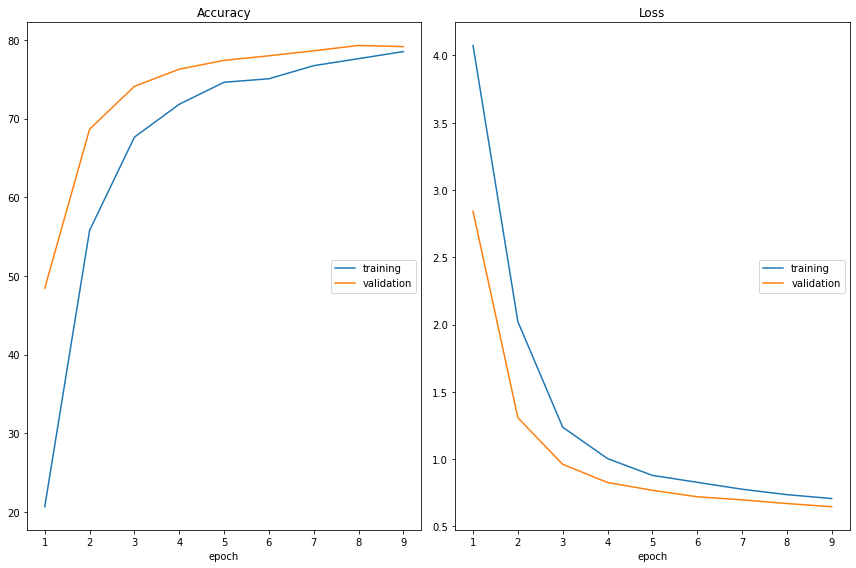

Accuracy
	training         	 (min:   20.669, max:   78.523, cur:   78.523)
	validation       	 (min:   48.445, max:   79.300, cur:   79.155)
Loss
	training         	 (min:    0.707, max:    4.074, cur:    0.707)
	validation       	 (min:    0.646, max:    2.842, cur:    0.646)
Test steps: 17 17.89s test_loss: 0.638272 test_acc: 80.223518                               
Test:
	Loss:  0.638
	Accuracy:  80.224


In [ ]:
train_model(model_name='model_googlenet', pytorch_model=model_googlenet)

##### Since our most successful model is Xception, we continue with it in the next steps. Let's examine what success rate is achieved in which dog breed below.

In [ ]:
def evaluate(model, test_loader, criterion):
  
    classes = []
    acc_results = np.zeros(len(test_loader.dataset))
    i = 0

    model.eval()
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.cuda(), labels.cuda()
            output = model(data)

            for pred, true in zip(output, labels):
                _, pred = pred.unsqueeze(0).topk(1)
                correct = pred.eq(true.unsqueeze(0))
                acc_results[i] = correct.cpu()
                classes.append(model.idx_to_class[true.item()][10:])
                i+=1

    results = pd.DataFrame({
      'class': classes,
      'results': acc_results    
    })
    results = results.groupby(classes).mean()

    return results

loss_function = nn.CrossEntropyLoss()
print(evaluate(model_xception, test_loader, loss_function))
breed_results = pd.DataFrame(evaluate(model_xception, test_loader, loss_function))

                                 results
Afghan_hound                    1.000000
African_hunting_dog             1.000000
Airedale                        1.000000
American_Staffordshire_terrier  0.285714
Appenzeller                     0.625000
...                                  ...
toy_poodle                      0.555556
toy_terrier                     0.875000
vizsla                          0.888889
whippet                         1.000000
wire-haired_fox_terrier         0.823529

[120 rows x 1 columns]


In [ ]:
breed_results.reset_index(inplace=True)
breed_results.rename(columns={"index" : "breed"}, inplace=True)

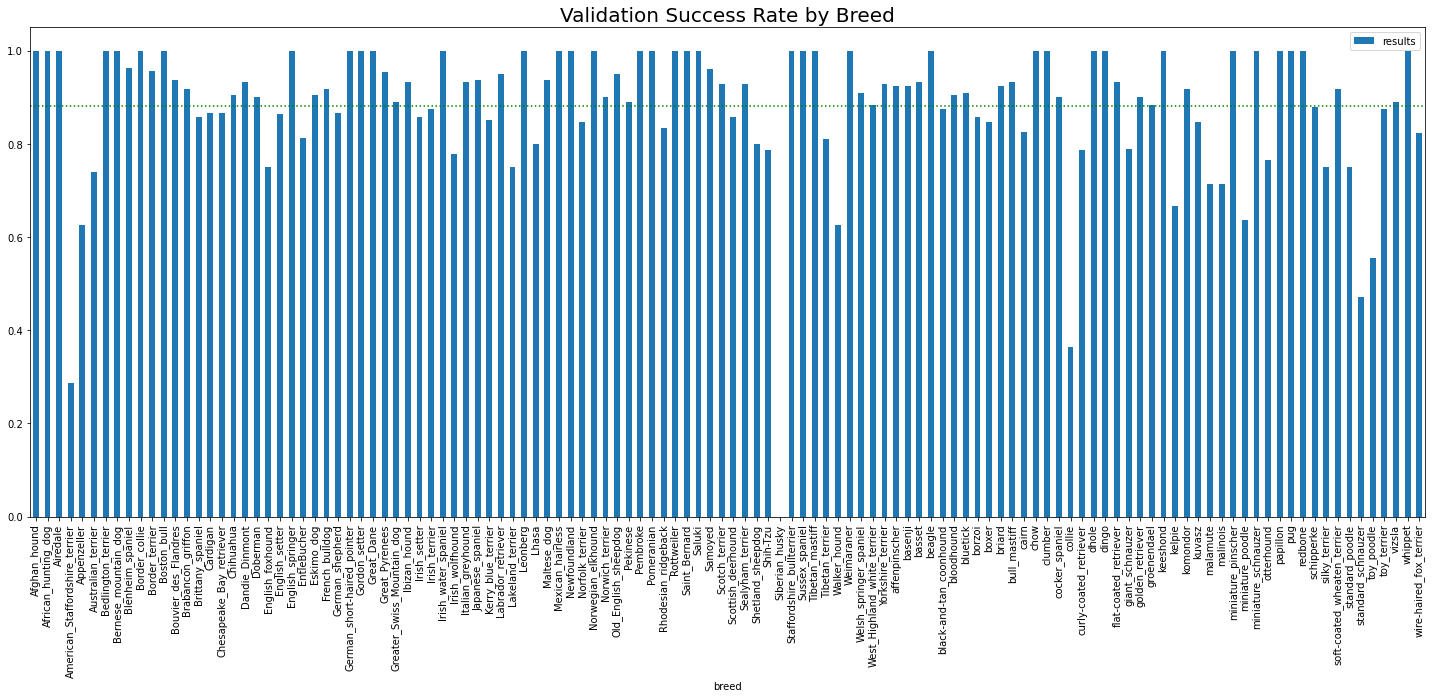

In [ ]:
fig = breed_results.plot(kind = "bar",x = "breed" ,figsize = (25,9))
mean_of_success_rate = breed_results["results"].mean()
fig.axhline(mean_of_success_rate, color = "g", linestyle = ":", label = "Mean of Success Rate")
plt.title("Validation Success Rate by Breed", fontsize = 20)
plt.show()

##### As you can see above, the success rate in the siberian husky is zero. I did not encounter such a situation when I did the same test for other models. Frankly, I couldn't find a reason why we encountered such a thing in Xception ):

In [ ]:
breed_results.sort_values(by = "results")

,breed,results
64,Siberian_husky,0.000000
3,American_Staffordshire_terrier,0.285714
89,collie,0.363636
114,standard_schnauzer,0.470588
115,toy_poodle,0.555556
...,...,...
91,dhole,1.000000
92,dingo,1.000000
66,Sussex_spaniel,1.000000
48,Norwegian_elkhound,1.000000


### Model Comparison

In [ ]:
import plotly.graph_objects as go

Epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Xception = [77, 86, 89.4, 89.2]
ResNet18 = [57, 72, 74, 78, 79.9, 76.2]
ResNet50 = [62, 81, 82, 84, 84.4, 85.7, 88.1, 86.7]
GoogleNet = [49, 68, 74, 76, 76.7, 77, 77.2, 79.3, 79.1]

fig = go.Figure()

fig.add_trace(go.Scatter(x=Epochs, y=Xception, name='Xception',
                         line=dict(color='#636EFA', width=3)))
fig.add_trace(go.Scatter(x=Epochs, y=ResNet18, name = 'ResNet18',
                         line=dict(color='#EF553B', width=3)))
fig.add_trace(go.Scatter(x=Epochs, y=ResNet50, name='ResNet50',
                         line=dict(color='#00CC96', width=3)
))
fig.add_trace(go.Scatter(x=Epochs, y=GoogleNet, name='GoogleNet',
                         line = dict(color='#AB63FA', width=3)))

fig.update_layout(title='Validation Results by Models',
                   xaxis_title='Epochs',
                   yaxis_title='Results')


fig.show()